In [1]:
from gerrychain import Graph

In [2]:
# Read Alabama county graph from the json file "AL_county.json"
filepath = 'C:\\Users\\blrod\\Downloads\\districting-data-2020-county\\'
filename = 'AL_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
# For each node, print the node #, county name, population, and lat-long coordinates
for node in G.nodes:
    name = G.nodes[node]["NAME20"]
    population = G.nodes[node]['P0010001']
    G.nodes[node]['TOTPOP'] = population
    
    # query lat and long coordinates 
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']  #longitude of county's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']  #latitude of county's center
    
    print("Node",node,"is",name,"County, which has population",population,"and is centered at (",G.nodes[node]['C_X'],",",G.nodes[node]['C_Y'], ")")

Node 0 is Shelby County, which has population 223024 and is centered at ( -086.6780894 , +33.2630428 )
Node 1 is Dallas County, which has population 38462 and is centered at ( -087.1143600 , +32.3335263 )
Node 2 is Pickens County, which has population 19123 and is centered at ( -088.0968644 , +33.2968003 )
Node 3 is Lauderdale County, which has population 93564 and is centered at ( -087.6509966 , +34.9041221 )
Node 4 is Cleburne County, which has population 15056 and is centered at ( -085.5161261 , +33.6719637 )
Node 5 is Barbour County, which has population 25223 and is centered at ( -085.4051035 , +31.8702531 )
Node 6 is Geneva County, which has population 26659 and is centered at ( -085.8210224 , +31.0923822 )
Node 7 is Dale County, which has population 49326 and is centered at ( -085.6094760 , +31.4306536 )
Node 8 is Tallapoosa County, which has population 41311 and is centered at ( -085.7996176 , +32.8633076 )
Node 9 is Clarke County, which has population 23087 and is centered at 

In [4]:
pip install geopy

In [5]:
from geopy.distance import geodesic

# create distance dictionary
dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = (G.nodes[i]['C_Y'],G.nodes[i]['C_X'])
        loc_j = (G.nodes[j]['C_Y'],G.nodes[j]['C_X'])
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [6]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 7          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 714166 and U = 721342 and k = 7


In [7]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m =gp.Model()

# create x[i,j] variable which equals one when county i 
#    is assigned to (the district centered at) county j
x =m.addVars( G.nodes, G.nodes, vtype=GRB.BINARY)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-06-09


In [8]:
# objective is to minimize the moment of inertia: sum (d^2 * p * x over all i and j)
m.setObjective( gp.quicksum( dist[i,j] * dist[i,j] *G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE)

In [9]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes)

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [10]:
# add contiguity constraints
import networkx as nx
DG = nx.DiGraph(G)

#add flow variables
f = m.addVars( DG.edges, G.nodes ) # f[i,j,v] = flow across arc (i,j) that is sent from source/root v

#add constraints saying that if node i is assigned to node j
# then node i must consume one unit of node j's flow
m.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node i can recieve flow of type j
#only if node i is assigned to node j
M = G.number_of_nodes() - 1
m.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j )

#add constraints saying that j cannot recieve flow of its own type
m.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )
             

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [11]:
# solve, making sure to set a 0.00% MIP gap tolerance(!)
m.Params.MIPGap = 0.0

m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 13602 rows, 27403 columns and 99280 nonzeros
Model fingerprint: 0xf2194a25
Variable types: 22914 continuous, 4489 integer (4489 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [3e+06, 4e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 575 rows and 1552 columns
Presolve time: 1.62s
Presolved: 13027 rows, 25851 columns, 95568 nonzeros
Variable types: 21445 continuous, 4406 integer (4406 binary)

Root relaxation: objective 5.572088e+09, 1832 iterations, 0.65 seconds (0.25 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/No

In [12]:
# print the objective value
print(m.objVal)

# retrieve the districts and their populations
#    but first get the district "centers"

centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in centers]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

6593085384.640669
District 0 has population 714963 and contains counties ['Cleburne', 'Tallapoosa', 'Crenshaw', 'Calhoun', 'Elmore', 'Randolph', 'Clay', 'Cherokee', 'Lee', 'Chambers', 'Lowndes', 'Talladega', 'Autauga', 'Macon']

District 1 has population 720310 and contains counties ['Jefferson', 'Bibb', 'Hale', 'Perry']

District 2 has population 717488 and contains counties ['Clarke', 'Washington', 'Mobile', 'Monroe', 'Baldwin', 'Choctaw']

District 3 has population 718247 and contains counties ['Shelby', 'Dallas', 'Pickens', 'Walker', 'Chilton', 'Marengo', 'Greene', 'Fayette', 'Tuscaloosa', 'Wilcox', 'Coosa', 'Sumter', 'Winston']

District 4 has population 719832 and contains counties ['Lawrence', 'Morgan', 'Etowah', 'DeKalb', 'Marshall', 'Blount', 'Jackson', 'St. Clair', 'Cullman']

District 5 has population 717940 and contains counties ['Lauderdale', 'Madison', 'Lamar', 'Franklin', 'Colbert', 'Limestone', 'Marion']

District 6 has population 715499 and contains counties ['Barbour'

In [13]:
# Let's draw it on a map
import geopandas as gpd

In [14]:
# Read Alabama county shapefile from "AL_county.shp"
filepath = 'C:\\Users\\blrod\\Downloads\\districting-data-2020-county\\'
filename = 'AL_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

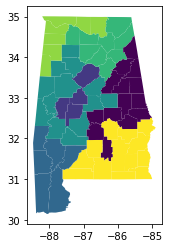

In [15]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling  = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = {G.nodes[i]['GEOID20'] : i for i in G.nodes}

#pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has thus geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]

#now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()